<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[22:09:54] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


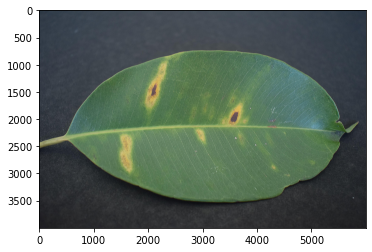

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

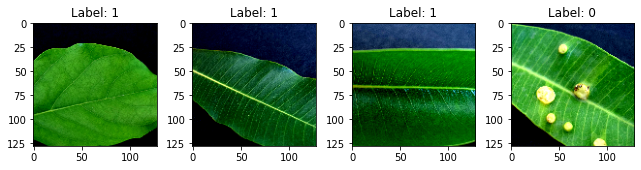

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[22:10:02] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[22:10:04] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2481053807847808 samples/sec                   batch loss = 1.4844200611114502 | accuracy = 0.65


Epoch[1] Batch[10] Speed: 1.261022701273228 samples/sec                   batch loss = 0.6047292947769165 | accuracy = 0.65


Epoch[1] Batch[15] Speed: 1.2674874871502055 samples/sec                   batch loss = 0.35158154368400574 | accuracy = 0.6166666666666667


Epoch[1] Batch[20] Speed: 1.2588384485445436 samples/sec                   batch loss = 0.5490933656692505 | accuracy = 0.625


Epoch[1] Batch[25] Speed: 1.2578725485690225 samples/sec                   batch loss = 1.2955281734466553 | accuracy = 0.66


Epoch[1] Batch[30] Speed: 1.2557161029876034 samples/sec                   batch loss = 0.4416346848011017 | accuracy = 0.6416666666666667


Epoch[1] Batch[35] Speed: 1.256319877072888 samples/sec                   batch loss = 0.2527359127998352 | accuracy = 0.6428571428571429


Epoch[1] Batch[40] Speed: 1.2602044108314139 samples/sec                   batch loss = 0.253336638212204 | accuracy = 0.6625


Epoch[1] Batch[45] Speed: 1.259546590086339 samples/sec                   batch loss = 0.29701346158981323 | accuracy = 0.6722222222222223


Epoch[1] Batch[50] Speed: 1.262000851502993 samples/sec                   batch loss = 0.8052152395248413 | accuracy = 0.66


Epoch[1] Batch[55] Speed: 1.258750612504799 samples/sec                   batch loss = 1.1913164854049683 | accuracy = 0.6636363636363637


Epoch[1] Batch[60] Speed: 1.262492585952161 samples/sec                   batch loss = 0.6366835236549377 | accuracy = 0.65


Epoch[1] Batch[65] Speed: 1.261199589312935 samples/sec                   batch loss = 0.38151630759239197 | accuracy = 0.6615384615384615


Epoch[1] Batch[70] Speed: 1.2567292426425507 samples/sec                   batch loss = 0.8765878677368164 | accuracy = 0.65


Epoch[1] Batch[75] Speed: 1.2584324275791852 samples/sec                   batch loss = 0.7447088956832886 | accuracy = 0.64


Epoch[1] Batch[80] Speed: 1.2530636065928358 samples/sec                   batch loss = 0.4315626323223114 | accuracy = 0.646875


Epoch[1] Batch[85] Speed: 1.2545188305136745 samples/sec                   batch loss = 0.9905030727386475 | accuracy = 0.6441176470588236


Epoch[1] Batch[90] Speed: 1.260492050632706 samples/sec                   batch loss = 0.4944447875022888 | accuracy = 0.65


Epoch[1] Batch[95] Speed: 1.2558121639976605 samples/sec                   batch loss = 1.5611804723739624 | accuracy = 0.6526315789473685


Epoch[1] Batch[100] Speed: 1.261982720303865 samples/sec                   batch loss = 0.5591580271720886 | accuracy = 0.655


Epoch[1] Batch[105] Speed: 1.2583842889777772 samples/sec                   batch loss = 0.7779133915901184 | accuracy = 0.6523809523809524


Epoch[1] Batch[110] Speed: 1.2615334039247568 samples/sec                   batch loss = 0.20808322727680206 | accuracy = 0.6568181818181819


Epoch[1] Batch[115] Speed: 1.2546117999742157 samples/sec                   batch loss = 0.7596936821937561 | accuracy = 0.65


Epoch[1] Batch[120] Speed: 1.2558339724577905 samples/sec                   batch loss = 0.345892995595932 | accuracy = 0.6541666666666667


Epoch[1] Batch[125] Speed: 1.2526581216925607 samples/sec                   batch loss = 0.9736688137054443 | accuracy = 0.654


Epoch[1] Batch[130] Speed: 1.257747978648022 samples/sec                   batch loss = 0.5066123008728027 | accuracy = 0.65


Epoch[1] Batch[135] Speed: 1.2606328886222602 samples/sec                   batch loss = 0.6579881906509399 | accuracy = 0.6537037037037037


Epoch[1] Batch[140] Speed: 1.262766254189911 samples/sec                   batch loss = 0.5060243010520935 | accuracy = 0.6553571428571429


Epoch[1] Batch[145] Speed: 1.2645076778075617 samples/sec                   batch loss = 0.6696254014968872 | accuracy = 0.6551724137931034


Epoch[1] Batch[150] Speed: 1.2598949517814964 samples/sec                   batch loss = 0.5720919370651245 | accuracy = 0.6633333333333333


Epoch[1] Batch[155] Speed: 1.2669204804494494 samples/sec                   batch loss = 0.9807432889938354 | accuracy = 0.6629032258064517


Epoch[1] Batch[160] Speed: 1.2632280531351587 samples/sec                   batch loss = 0.2778191864490509 | accuracy = 0.66875


Epoch[1] Batch[165] Speed: 1.2598528506009625 samples/sec                   batch loss = 0.5702301263809204 | accuracy = 0.6681818181818182


Epoch[1] Batch[170] Speed: 1.258892478520053 samples/sec                   batch loss = 0.7419089674949646 | accuracy = 0.6661764705882353


Epoch[1] Batch[175] Speed: 1.2583446481889318 samples/sec                   batch loss = 0.7525279521942139 | accuracy = 0.6671428571428571


Epoch[1] Batch[180] Speed: 1.2630760795352012 samples/sec                   batch loss = 0.26714158058166504 | accuracy = 0.6708333333333333


Epoch[1] Batch[185] Speed: 1.2635402938542513 samples/sec                   batch loss = 0.9132018685340881 | accuracy = 0.6662162162162162


Epoch[1] Batch[190] Speed: 1.263175932911969 samples/sec                   batch loss = 0.46299344301223755 | accuracy = 0.6697368421052632


Epoch[1] Batch[195] Speed: 1.2660837237550608 samples/sec                   batch loss = 0.24577632546424866 | accuracy = 0.676923076923077


Epoch[1] Batch[200] Speed: 1.261130382830867 samples/sec                   batch loss = 0.19351550936698914 | accuracy = 0.67875


Epoch[1] Batch[205] Speed: 1.257527283613387 samples/sec                   batch loss = 0.7085990309715271 | accuracy = 0.675609756097561


Epoch[1] Batch[210] Speed: 1.2542272528552982 samples/sec                   batch loss = 1.3827112913131714 | accuracy = 0.669047619047619


Epoch[1] Batch[215] Speed: 1.255060611233654 samples/sec                   batch loss = 0.3302469849586487 | accuracy = 0.6709302325581395


Epoch[1] Batch[220] Speed: 1.2581197811798142 samples/sec                   batch loss = 0.7211152911186218 | accuracy = 0.6670454545454545


Epoch[1] Batch[225] Speed: 1.2533800184048833 samples/sec                   batch loss = 0.27212533354759216 | accuracy = 0.6688888888888889


Epoch[1] Batch[230] Speed: 1.2592438809581388 samples/sec                   batch loss = 0.7985936999320984 | accuracy = 0.6652173913043479


Epoch[1] Batch[235] Speed: 1.2581888463373505 samples/sec                   batch loss = 0.6184444427490234 | accuracy = 0.6627659574468086


Epoch[1] Batch[240] Speed: 1.2581388393865502 samples/sec                   batch loss = 0.52056884765625 | accuracy = 0.6635416666666667


Epoch[1] Batch[245] Speed: 1.2660563986641569 samples/sec                   batch loss = 0.42484867572784424 | accuracy = 0.6663265306122449


Epoch[1] Batch[250] Speed: 1.2641160889232472 samples/sec                   batch loss = 0.6313376426696777 | accuracy = 0.671


Epoch[1] Batch[255] Speed: 1.2672755181037083 samples/sec                   batch loss = 0.2896517813205719 | accuracy = 0.6715686274509803


Epoch[1] Batch[260] Speed: 1.256429297424147 samples/sec                   batch loss = 0.7073574066162109 | accuracy = 0.6711538461538461


Epoch[1] Batch[265] Speed: 1.2551950730730044 samples/sec                   batch loss = 0.4576307237148285 | accuracy = 0.6764150943396227


Epoch[1] Batch[270] Speed: 1.2477742721583993 samples/sec                   batch loss = 0.6054452657699585 | accuracy = 0.675


Epoch[1] Batch[275] Speed: 1.2542536008770766 samples/sec                   batch loss = 1.239780306816101 | accuracy = 0.6736363636363636


Epoch[1] Batch[280] Speed: 1.2554336447095942 samples/sec                   batch loss = 0.6968673467636108 | accuracy = 0.6723214285714286


Epoch[1] Batch[285] Speed: 1.2630417526400297 samples/sec                   batch loss = 1.081782341003418 | accuracy = 0.6736842105263158


Epoch[1] Batch[290] Speed: 1.2619429474040504 samples/sec                   batch loss = 0.4754588007926941 | accuracy = 0.675


Epoch[1] Batch[295] Speed: 1.2540536273876943 samples/sec                   batch loss = 0.5989788770675659 | accuracy = 0.6745762711864407


Epoch[1] Batch[300] Speed: 1.260019379580063 samples/sec                   batch loss = 0.12686820328235626 | accuracy = 0.6766666666666666


Epoch[1] Batch[305] Speed: 1.2477983080527955 samples/sec                   batch loss = 0.2902926802635193 | accuracy = 0.6762295081967213


Epoch[1] Batch[310] Speed: 1.2454305417326694 samples/sec                   batch loss = 0.9363308548927307 | accuracy = 0.6741935483870968


Epoch[1] Batch[315] Speed: 1.2475445394510338 samples/sec                   batch loss = 0.490923136472702 | accuracy = 0.6730158730158731


Epoch[1] Batch[320] Speed: 1.2520842116355537 samples/sec                   batch loss = 0.6338397264480591 | accuracy = 0.67421875


Epoch[1] Batch[325] Speed: 1.2514838474729595 samples/sec                   batch loss = 0.9850578904151917 | accuracy = 0.6746153846153846


Epoch[1] Batch[330] Speed: 1.2597741431325886 samples/sec                   batch loss = 0.9092977046966553 | accuracy = 0.6727272727272727


Epoch[1] Batch[335] Speed: 1.2509585811805521 samples/sec                   batch loss = 0.3339287340641022 | accuracy = 0.6738805970149254


Epoch[1] Batch[340] Speed: 1.253754583072745 samples/sec                   batch loss = 0.858354926109314 | accuracy = 0.6727941176470589


Epoch[1] Batch[345] Speed: 1.2667519311545763 samples/sec                   batch loss = 0.522245466709137 | accuracy = 0.672463768115942


Epoch[1] Batch[350] Speed: 1.2596651797948613 samples/sec                   batch loss = 0.4884015619754791 | accuracy = 0.6757142857142857


Epoch[1] Batch[355] Speed: 1.255105866820596 samples/sec                   batch loss = 0.8539093732833862 | accuracy = 0.673943661971831


Epoch[1] Batch[360] Speed: 1.250199223019048 samples/sec                   batch loss = 0.44745612144470215 | accuracy = 0.6743055555555556


Epoch[1] Batch[365] Speed: 1.251703453432001 samples/sec                   batch loss = 0.29682400822639465 | accuracy = 0.673972602739726


Epoch[1] Batch[370] Speed: 1.2562834705715062 samples/sec                   batch loss = 0.1681913584470749 | accuracy = 0.675


Epoch[1] Batch[375] Speed: 1.2590077327759162 samples/sec                   batch loss = 0.9459843635559082 | accuracy = 0.674


Epoch[1] Batch[380] Speed: 1.261320861175522 samples/sec                   batch loss = 0.7995454668998718 | accuracy = 0.6710526315789473


Epoch[1] Batch[385] Speed: 1.2534041771134348 samples/sec                   batch loss = 0.39125505089759827 | accuracy = 0.6701298701298701


Epoch[1] Batch[390] Speed: 1.2558751473914482 samples/sec                   batch loss = 0.37526756525039673 | accuracy = 0.6705128205128205


Epoch[1] Batch[395] Speed: 1.2561429443365955 samples/sec                   batch loss = 0.9348482489585876 | accuracy = 0.6708860759493671


Epoch[1] Batch[400] Speed: 1.2504215469521023 samples/sec                   batch loss = 0.27974003553390503 | accuracy = 0.670625


Epoch[1] Batch[405] Speed: 1.2487402414815345 samples/sec                   batch loss = 0.4878140091896057 | accuracy = 0.6685185185185185


Epoch[1] Batch[410] Speed: 1.2496304487305059 samples/sec                   batch loss = 0.4827428460121155 | accuracy = 0.6701219512195122


Epoch[1] Batch[415] Speed: 1.255924880534463 samples/sec                   batch loss = 0.5108767747879028 | accuracy = 0.6710843373493975


Epoch[1] Batch[420] Speed: 1.2634504684014556 samples/sec                   batch loss = 0.3814934194087982 | accuracy = 0.6702380952380952


Epoch[1] Batch[425] Speed: 1.2647472287036405 samples/sec                   batch loss = 0.2918587327003479 | accuracy = 0.6705882352941176


Epoch[1] Batch[430] Speed: 1.263791092455256 samples/sec                   batch loss = 0.29526373744010925 | accuracy = 0.6715116279069767


Epoch[1] Batch[435] Speed: 1.2613945459316283 samples/sec                   batch loss = 0.9568606615066528 | accuracy = 0.6718390804597701


Epoch[1] Batch[440] Speed: 1.2549820320034624 samples/sec                   batch loss = 0.5954763889312744 | accuracy = 0.6721590909090909


Epoch[1] Batch[445] Speed: 1.2467726415960863 samples/sec                   batch loss = 0.5425688028335571 | accuracy = 0.6719101123595506


Epoch[1] Batch[450] Speed: 1.2489040314061413 samples/sec                   batch loss = 0.4214877784252167 | accuracy = 0.6722222222222223


Epoch[1] Batch[455] Speed: 1.2510360976348884 samples/sec                   batch loss = 0.3954631984233856 | accuracy = 0.6747252747252748


Epoch[1] Batch[460] Speed: 1.2523187042516184 samples/sec                   batch loss = 0.38562339544296265 | accuracy = 0.6744565217391304


Epoch[1] Batch[465] Speed: 1.2412353539702115 samples/sec                   batch loss = 0.7686138153076172 | accuracy = 0.6736559139784947


Epoch[1] Batch[470] Speed: 1.246778293391536 samples/sec                   batch loss = 0.6233457922935486 | accuracy = 0.6728723404255319


Epoch[1] Batch[475] Speed: 1.255719204532297 samples/sec                   batch loss = 0.44957655668258667 | accuracy = 0.6736842105263158


Epoch[1] Batch[480] Speed: 1.2602422755850038 samples/sec                   batch loss = 0.3136194348335266 | accuracy = 0.6755208333333333


Epoch[1] Batch[485] Speed: 1.257927627467471 samples/sec                   batch loss = 0.2007603943347931 | accuracy = 0.6778350515463918


Epoch[1] Batch[490] Speed: 1.2606436871846554 samples/sec                   batch loss = 0.6422551870346069 | accuracy = 0.6785714285714286


Epoch[1] Batch[495] Speed: 1.2536496561717483 samples/sec                   batch loss = 0.27855950593948364 | accuracy = 0.6797979797979798


Epoch[1] Batch[500] Speed: 1.2458558764476195 samples/sec                   batch loss = 0.8105366230010986 | accuracy = 0.6805


Epoch[1] Batch[505] Speed: 1.248744702839877 samples/sec                   batch loss = 2.1693334579467773 | accuracy = 0.6792079207920793


Epoch[1] Batch[510] Speed: 1.2473635778242027 samples/sec                   batch loss = 0.6106818914413452 | accuracy = 0.6794117647058824


Epoch[1] Batch[515] Speed: 1.2582742447545519 samples/sec                   batch loss = 0.3306558430194855 | accuracy = 0.6786407766990291


Epoch[1] Batch[520] Speed: 1.2572079267898815 samples/sec                   batch loss = 0.31397363543510437 | accuracy = 0.6783653846153846


Epoch[1] Batch[525] Speed: 1.2589887427129 samples/sec                   batch loss = 0.20870204269886017 | accuracy = 0.679047619047619


Epoch[1] Batch[530] Speed: 1.255040425665452 samples/sec                   batch loss = 0.4634776711463928 | accuracy = 0.6797169811320755


Epoch[1] Batch[535] Speed: 1.2531458770149175 samples/sec                   batch loss = 1.3327865600585938 | accuracy = 0.6799065420560748


Epoch[1] Batch[540] Speed: 1.2474383305940406 samples/sec                   batch loss = 0.6273387670516968 | accuracy = 0.6800925925925926


Epoch[1] Batch[545] Speed: 1.251361379667642 samples/sec                   batch loss = 0.3321493864059448 | accuracy = 0.681651376146789


Epoch[1] Batch[550] Speed: 1.2508551475899858 samples/sec                   batch loss = 0.44281238317489624 | accuracy = 0.6813636363636364


Epoch[1] Batch[555] Speed: 1.2437476851927358 samples/sec                   batch loss = 0.49415406584739685 | accuracy = 0.681981981981982


Epoch[1] Batch[560] Speed: 1.2427528743984648 samples/sec                   batch loss = 0.35026395320892334 | accuracy = 0.6834821428571428


Epoch[1] Batch[565] Speed: 1.2480156939839753 samples/sec                   batch loss = 0.14243970811367035 | accuracy = 0.6849557522123894


Epoch[1] Batch[570] Speed: 1.2551218291132147 samples/sec                   batch loss = 0.33878716826438904 | accuracy = 0.6850877192982456


Epoch[1] Batch[575] Speed: 1.2474547477247275 samples/sec                   batch loss = 0.2111014574766159 | accuracy = 0.6865217391304348


Epoch[1] Batch[580] Speed: 1.2485646937509758 samples/sec                   batch loss = 0.4199259579181671 | accuracy = 0.6875


Epoch[1] Batch[585] Speed: 1.2468595551971087 samples/sec                   batch loss = 0.6920847296714783 | accuracy = 0.6867521367521368


Epoch[1] Batch[590] Speed: 1.2435241333003353 samples/sec                   batch loss = 0.8862168788909912 | accuracy = 0.686864406779661


Epoch[1] Batch[595] Speed: 1.2455318780266047 samples/sec                   batch loss = 0.422013521194458 | accuracy = 0.688655462184874


Epoch[1] Batch[600] Speed: 1.2456963072043414 samples/sec                   batch loss = 0.33786913752555847 | accuracy = 0.6908333333333333


Epoch[1] Batch[605] Speed: 1.2449949650223031 samples/sec                   batch loss = 0.5363537669181824 | accuracy = 0.6917355371900826


Epoch[1] Batch[610] Speed: 1.2557838705295041 samples/sec                   batch loss = 0.7187644839286804 | accuracy = 0.6913934426229508


Epoch[1] Batch[615] Speed: 1.2529431687022903 samples/sec                   batch loss = 0.9591262936592102 | accuracy = 0.6922764227642276


Epoch[1] Batch[620] Speed: 1.2610185308785842 samples/sec                   batch loss = 0.33947065472602844 | accuracy = 0.6911290322580645


Epoch[1] Batch[625] Speed: 1.2611647955157024 samples/sec                   batch loss = 0.7094346284866333 | accuracy = 0.69


Epoch[1] Batch[630] Speed: 1.2618316156012637 samples/sec                   batch loss = 0.41397324204444885 | accuracy = 0.6904761904761905


Epoch[1] Batch[635] Speed: 1.254847991225676 samples/sec                   batch loss = 0.9611920714378357 | accuracy = 0.6901574803149606


Epoch[1] Batch[640] Speed: 1.2560924415833195 samples/sec                   batch loss = 0.6117881536483765 | accuracy = 0.690625


Epoch[1] Batch[645] Speed: 1.2534309587857604 samples/sec                   batch loss = 0.4838629961013794 | accuracy = 0.6914728682170542


Epoch[1] Batch[650] Speed: 1.2573254169141328 samples/sec                   batch loss = 0.2804372310638428 | accuracy = 0.6926923076923077


Epoch[1] Batch[655] Speed: 1.2634231617117149 samples/sec                   batch loss = 0.43030983209609985 | accuracy = 0.6938931297709924


Epoch[1] Batch[660] Speed: 1.2613366026267971 samples/sec                   batch loss = 0.7326760292053223 | accuracy = 0.693939393939394


Epoch[1] Batch[665] Speed: 1.261258088934052 samples/sec                   batch loss = 0.1981477439403534 | accuracy = 0.6947368421052632


Epoch[1] Batch[670] Speed: 1.2636847645356337 samples/sec                   batch loss = 0.37536609172821045 | accuracy = 0.6955223880597015


Epoch[1] Batch[675] Speed: 1.2629336493750791 samples/sec                   batch loss = 0.21743451058864594 | accuracy = 0.6955555555555556


Epoch[1] Batch[680] Speed: 1.2545784944967733 samples/sec                   batch loss = 0.29697850346565247 | accuracy = 0.6959558823529411


Epoch[1] Batch[685] Speed: 1.2630700888346102 samples/sec                   batch loss = 0.3270367681980133 | accuracy = 0.6956204379562044


Epoch[1] Batch[690] Speed: 1.2549745219590036 samples/sec                   batch loss = 0.31743618845939636 | accuracy = 0.6960144927536231


Epoch[1] Batch[695] Speed: 1.2495507797284167 samples/sec                   batch loss = 0.5322611331939697 | accuracy = 0.6967625899280575


Epoch[1] Batch[700] Speed: 1.2456658780595156 samples/sec                   batch loss = 0.7675178050994873 | accuracy = 0.6967857142857142


Epoch[1] Batch[705] Speed: 1.2465593932542962 samples/sec                   batch loss = 0.383367657661438 | accuracy = 0.6971631205673758


Epoch[1] Batch[710] Speed: 1.2489503316930262 samples/sec                   batch loss = 0.678507387638092 | accuracy = 0.6978873239436619


Epoch[1] Batch[715] Speed: 1.251932291609535 samples/sec                   batch loss = 0.4691143333911896 | accuracy = 0.6986013986013986


Epoch[1] Batch[720] Speed: 1.2567447755536811 samples/sec                   batch loss = 0.42626291513442993 | accuracy = 0.6982638888888889


Epoch[1] Batch[725] Speed: 1.2533435948258351 samples/sec                   batch loss = 0.7582703828811646 | accuracy = 0.6982758620689655


Epoch[1] Batch[730] Speed: 1.2509296665517926 samples/sec                   batch loss = 1.3642475605010986 | accuracy = 0.6996575342465754


Epoch[1] Batch[735] Speed: 1.2539753616484306 samples/sec                   batch loss = 0.30852556228637695 | accuracy = 0.7


Epoch[1] Batch[740] Speed: 1.2507543419485692 samples/sec                   batch loss = 0.26012325286865234 | accuracy = 0.7


Epoch[1] Batch[745] Speed: 1.2550435238732731 samples/sec                   batch loss = 0.633064329624176 | accuracy = 0.7006711409395974


Epoch[1] Batch[750] Speed: 1.2540160398672855 samples/sec                   batch loss = 0.35596904158592224 | accuracy = 0.7013333333333334


Epoch[1] Batch[755] Speed: 1.2551584500245836 samples/sec                   batch loss = 0.2228912115097046 | accuracy = 0.702317880794702


Epoch[1] Batch[760] Speed: 1.2650911280679216 samples/sec                   batch loss = 0.49914368987083435 | accuracy = 0.7032894736842106


Epoch[1] Batch[765] Speed: 1.264323000563011 samples/sec                   batch loss = 0.3293873071670532 | accuracy = 0.703921568627451


Epoch[1] Batch[770] Speed: 1.255291242224769 samples/sec                   batch loss = 0.46851617097854614 | accuracy = 0.7042207792207792


Epoch[1] Batch[775] Speed: 1.2463525139045597 samples/sec                   batch loss = 0.94219970703125 | accuracy = 0.7041935483870968


Epoch[1] Batch[780] Speed: 1.2500691824696017 samples/sec                   batch loss = 0.4779787063598633 | accuracy = 0.7041666666666667


Epoch[1] Batch[785] Speed: 1.2452488988703465 samples/sec                   batch loss = 0.44993695616722107 | accuracy = 0.7047770700636943


[Epoch 1] training: accuracy=0.7046319796954315
[Epoch 1] time cost: 654.3172087669373
[Epoch 1] validation: validation accuracy=0.75


Epoch[2] Batch[5] Speed: 1.250149010746732 samples/sec                   batch loss = 1.0309571027755737 | accuracy = 0.9


Epoch[2] Batch[10] Speed: 1.2504124139006327 samples/sec                   batch loss = 0.47181183099746704 | accuracy = 0.825


Epoch[2] Batch[15] Speed: 1.247708387003117 samples/sec                   batch loss = 0.5076753497123718 | accuracy = 0.85


Epoch[2] Batch[20] Speed: 1.2437719350334915 samples/sec                   batch loss = 0.3982391357421875 | accuracy = 0.875


Epoch[2] Batch[25] Speed: 1.2528288349588586 samples/sec                   batch loss = 0.5877431035041809 | accuracy = 0.88


Epoch[2] Batch[30] Speed: 1.253195862273479 samples/sec                   batch loss = 1.4725698232650757 | accuracy = 0.825


Epoch[2] Batch[35] Speed: 1.2467572615597218 samples/sec                   batch loss = 0.24003487825393677 | accuracy = 0.8285714285714286


Epoch[2] Batch[40] Speed: 1.2476429727118703 samples/sec                   batch loss = 0.2913902997970581 | accuracy = 0.8375


Epoch[2] Batch[45] Speed: 1.2482320412434305 samples/sec                   batch loss = 0.896287739276886 | accuracy = 0.8222222222222222


Epoch[2] Batch[50] Speed: 1.254533745977423 samples/sec                   batch loss = 0.6838836669921875 | accuracy = 0.805


Epoch[2] Batch[55] Speed: 1.2512791567335806 samples/sec                   batch loss = 0.1265701800584793 | accuracy = 0.8090909090909091


Epoch[2] Batch[60] Speed: 1.2549700159754722 samples/sec                   batch loss = 0.3300614356994629 | accuracy = 0.8041666666666667


Epoch[2] Batch[65] Speed: 1.25588285624073 samples/sec                   batch loss = 0.584004819393158 | accuracy = 0.7961538461538461


Epoch[2] Batch[70] Speed: 1.2556841485707375 samples/sec                   batch loss = 1.0392165184020996 | accuracy = 0.7964285714285714


Epoch[2] Batch[75] Speed: 1.2570795324656447 samples/sec                   batch loss = 0.524570107460022 | accuracy = 0.7966666666666666


Epoch[2] Batch[80] Speed: 1.250139136451634 samples/sec                   batch loss = 0.5940908193588257 | accuracy = 0.796875


Epoch[2] Batch[85] Speed: 1.2498975442887674 samples/sec                   batch loss = 0.32318824529647827 | accuracy = 0.7970588235294118


Epoch[2] Batch[90] Speed: 1.2450805221359806 samples/sec                   batch loss = 0.46724385023117065 | accuracy = 0.7861111111111111


Epoch[2] Batch[95] Speed: 1.2447976556526086 samples/sec                   batch loss = 0.48723453283309937 | accuracy = 0.7842105263157895


Epoch[2] Batch[100] Speed: 1.2487269505404208 samples/sec                   batch loss = 0.633573591709137 | accuracy = 0.7875


Epoch[2] Batch[105] Speed: 1.2480733483047637 samples/sec                   batch loss = 0.3439840078353882 | accuracy = 0.7928571428571428


Epoch[2] Batch[110] Speed: 1.2535269514537835 samples/sec                   batch loss = 0.15954968333244324 | accuracy = 0.7954545454545454


Epoch[2] Batch[115] Speed: 1.2478421132998085 samples/sec                   batch loss = 0.4694882929325104 | accuracy = 0.7934782608695652


Epoch[2] Batch[120] Speed: 1.2431291269769997 samples/sec                   batch loss = 0.35256004333496094 | accuracy = 0.7875


Epoch[2] Batch[125] Speed: 1.2417227076533748 samples/sec                   batch loss = 0.16468912363052368 | accuracy = 0.788


Epoch[2] Batch[130] Speed: 1.2495774900492027 samples/sec                   batch loss = 0.7453469038009644 | accuracy = 0.7903846153846154


Epoch[2] Batch[135] Speed: 1.259616663124189 samples/sec                   batch loss = 0.5686888694763184 | accuracy = 0.7888888888888889


Epoch[2] Batch[140] Speed: 1.2529889267586354 samples/sec                   batch loss = 1.132275938987732 | accuracy = 0.7839285714285714


Epoch[2] Batch[145] Speed: 1.2468600185216936 samples/sec                   batch loss = 0.5909326672554016 | accuracy = 0.7810344827586206


Epoch[2] Batch[150] Speed: 1.2452840216017662 samples/sec                   batch loss = 0.33398202061653137 | accuracy = 0.7833333333333333


Epoch[2] Batch[155] Speed: 1.2537395924401156 samples/sec                   batch loss = 0.18697099387645721 | accuracy = 0.7790322580645161


Epoch[2] Batch[160] Speed: 1.2560207854277412 samples/sec                   batch loss = 0.23497934639453888 | accuracy = 0.78125


Epoch[2] Batch[165] Speed: 1.2545767119999462 samples/sec                   batch loss = 0.5441063046455383 | accuracy = 0.7803030303030303


Epoch[2] Batch[170] Speed: 1.2538618702502475 samples/sec                   batch loss = 0.3850051760673523 | accuracy = 0.7779411764705882


Epoch[2] Batch[175] Speed: 1.2498766864308586 samples/sec                   batch loss = 0.4906551241874695 | accuracy = 0.7742857142857142


Epoch[2] Batch[180] Speed: 1.2497572327362605 samples/sec                   batch loss = 0.668940007686615 | accuracy = 0.7722222222222223


Epoch[2] Batch[185] Speed: 1.2443032714512356 samples/sec                   batch loss = 0.8477796912193298 | accuracy = 0.772972972972973


Epoch[2] Batch[190] Speed: 1.247044541743604 samples/sec                   batch loss = 0.3548467457294464 | accuracy = 0.7723684210526316


Epoch[2] Batch[195] Speed: 1.2518565322386401 samples/sec                   batch loss = 0.30648258328437805 | accuracy = 0.7692307692307693


Epoch[2] Batch[200] Speed: 1.2566974249082956 samples/sec                   batch loss = 0.6304886937141418 | accuracy = 0.76625


Epoch[2] Batch[205] Speed: 1.2542029686483198 samples/sec                   batch loss = 0.32864582538604736 | accuracy = 0.7695121951219512


Epoch[2] Batch[210] Speed: 1.2567089092301111 samples/sec                   batch loss = 0.6841385364532471 | accuracy = 0.7690476190476191


Epoch[2] Batch[215] Speed: 1.2562742516889134 samples/sec                   batch loss = 0.25998836755752563 | accuracy = 0.772093023255814


Epoch[2] Batch[220] Speed: 1.2545823409545531 samples/sec                   batch loss = 0.4035344421863556 | accuracy = 0.775


Epoch[2] Batch[225] Speed: 1.2514884218111402 samples/sec                   batch loss = 0.35242778062820435 | accuracy = 0.7744444444444445


Epoch[2] Batch[230] Speed: 1.2450109483415046 samples/sec                   batch loss = 0.3719175457954407 | accuracy = 0.7739130434782608


Epoch[2] Batch[235] Speed: 1.2507518243468154 samples/sec                   batch loss = 0.42715567350387573 | accuracy = 0.776595744680851


Epoch[2] Batch[240] Speed: 1.2503012436748888 samples/sec                   batch loss = 0.4616170823574066 | accuracy = 0.7760416666666666


Epoch[2] Batch[245] Speed: 1.2465074354470589 samples/sec                   batch loss = 0.42459923028945923 | accuracy = 0.7755102040816326


Epoch[2] Batch[250] Speed: 1.2503316201643244 samples/sec                   batch loss = 0.8131511807441711 | accuracy = 0.776


Epoch[2] Batch[255] Speed: 1.2509410456977934 samples/sec                   batch loss = 0.33127450942993164 | accuracy = 0.7754901960784314


Epoch[2] Batch[260] Speed: 1.2539239084193663 samples/sec                   batch loss = 0.25279560685157776 | accuracy = 0.775


Epoch[2] Batch[265] Speed: 1.2512018900907458 samples/sec                   batch loss = 0.7459332942962646 | accuracy = 0.7754716981132076


Epoch[2] Batch[270] Speed: 1.2514777795249323 samples/sec                   batch loss = 0.39732441306114197 | accuracy = 0.7759259259259259


Epoch[2] Batch[275] Speed: 1.251193212187093 samples/sec                   batch loss = 0.7705948948860168 | accuracy = 0.7754545454545455


Epoch[2] Batch[280] Speed: 1.2502867082082125 samples/sec                   batch loss = 0.3678382635116577 | accuracy = 0.7776785714285714


Epoch[2] Batch[285] Speed: 1.254764371044088 samples/sec                   batch loss = 0.5001243948936462 | accuracy = 0.7736842105263158


Epoch[2] Batch[290] Speed: 1.2576305980875895 samples/sec                   batch loss = 0.6148675680160522 | accuracy = 0.7724137931034483


Epoch[2] Batch[295] Speed: 1.2623580758952078 samples/sec                   batch loss = 0.6395147442817688 | accuracy = 0.7720338983050847


Epoch[2] Batch[300] Speed: 1.259332069438693 samples/sec                   batch loss = 0.9215543270111084 | accuracy = 0.77


Epoch[2] Batch[305] Speed: 1.2641732400643644 samples/sec                   batch loss = 0.4073428809642792 | accuracy = 0.771311475409836


Epoch[2] Batch[310] Speed: 1.260494039383226 samples/sec                   batch loss = 0.45163238048553467 | accuracy = 0.7701612903225806


Epoch[2] Batch[315] Speed: 1.2558319043816495 samples/sec                   batch loss = 3.057875633239746 | accuracy = 0.7722222222222223


Epoch[2] Batch[320] Speed: 1.2497353555390602 samples/sec                   batch loss = 0.1563389003276825 | accuracy = 0.77421875


Epoch[2] Batch[325] Speed: 1.2537955280647946 samples/sec                   batch loss = 0.21739619970321655 | accuracy = 0.7761538461538462


Epoch[2] Batch[330] Speed: 1.2583795697052826 samples/sec                   batch loss = 0.18644088506698608 | accuracy = 0.7772727272727272


Epoch[2] Batch[335] Speed: 1.2607951707289469 samples/sec                   batch loss = 0.8245676755905151 | accuracy = 0.7753731343283582


Epoch[2] Batch[340] Speed: 1.2564889550672993 samples/sec                   batch loss = 0.6889106631278992 | accuracy = 0.7735294117647059


Epoch[2] Batch[345] Speed: 1.253411855657703 samples/sec                   batch loss = 1.934970498085022 | accuracy = 0.7710144927536232


Epoch[2] Batch[350] Speed: 1.2539264388073166 samples/sec                   batch loss = 1.025594711303711 | accuracy = 0.7707142857142857


Epoch[2] Batch[355] Speed: 1.2483395928085792 samples/sec                   batch loss = 0.75127774477005 | accuracy = 0.7697183098591549


Epoch[2] Batch[360] Speed: 1.2509524250508182 samples/sec                   batch loss = 0.8176340460777283 | accuracy = 0.7694444444444445


Epoch[2] Batch[365] Speed: 1.250943843880162 samples/sec                   batch loss = 0.22457070648670197 | accuracy = 0.7698630136986301


Epoch[2] Batch[370] Speed: 1.251878390351505 samples/sec                   batch loss = 0.22431081533432007 | accuracy = 0.7695945945945946


Epoch[2] Batch[375] Speed: 1.2588718861292743 samples/sec                   batch loss = 0.6813964247703552 | accuracy = 0.768


Epoch[2] Batch[380] Speed: 1.2516604038445929 samples/sec                   batch loss = 0.2566172778606415 | accuracy = 0.7690789473684211


Epoch[2] Batch[385] Speed: 1.2519587301449902 samples/sec                   batch loss = 0.40379682183265686 | accuracy = 0.7662337662337663


Epoch[2] Batch[390] Speed: 1.2535005402975772 samples/sec                   batch loss = 0.8146589994430542 | accuracy = 0.7660256410256411


Epoch[2] Batch[395] Speed: 1.2513139671676208 samples/sec                   batch loss = 0.5671011209487915 | accuracy = 0.7651898734177215


Epoch[2] Batch[400] Speed: 1.2533986523653906 samples/sec                   batch loss = 0.34500551223754883 | accuracy = 0.765


Epoch[2] Batch[405] Speed: 1.2534065181230596 samples/sec                   batch loss = 0.3396342694759369 | accuracy = 0.7660493827160494


Epoch[2] Batch[410] Speed: 1.255897428104597 samples/sec                   batch loss = 0.44461819529533386 | accuracy = 0.7676829268292683


Epoch[2] Batch[415] Speed: 1.2453771988674838 samples/sec                   batch loss = 0.8959474563598633 | accuracy = 0.7674698795180723


Epoch[2] Batch[420] Speed: 1.2529354023292036 samples/sec                   batch loss = 0.3888951241970062 | accuracy = 0.7678571428571429


Epoch[2] Batch[425] Speed: 1.2532753414285347 samples/sec                   batch loss = 0.4683946669101715 | accuracy = 0.7670588235294118


Epoch[2] Batch[430] Speed: 1.25878725658814 samples/sec                   batch loss = 0.6017308831214905 | accuracy = 0.766860465116279


Epoch[2] Batch[435] Speed: 1.2529244547137903 samples/sec                   batch loss = 0.5794237852096558 | accuracy = 0.7649425287356322


Epoch[2] Batch[440] Speed: 1.2535459644289524 samples/sec                   batch loss = 0.3049349784851074 | accuracy = 0.7670454545454546


Epoch[2] Batch[445] Speed: 1.250447642120038 samples/sec                   batch loss = 0.5619990825653076 | accuracy = 0.7657303370786517


Epoch[2] Batch[450] Speed: 1.2582156441505687 samples/sec                   batch loss = 0.7425218820571899 | accuracy = 0.7638888888888888


Epoch[2] Batch[455] Speed: 1.247777427396755 samples/sec                   batch loss = 0.9366647005081177 | accuracy = 0.7626373626373626


Epoch[2] Batch[460] Speed: 1.248064063835308 samples/sec                   batch loss = 1.1000819206237793 | accuracy = 0.7625


Epoch[2] Batch[465] Speed: 1.2480778977452238 samples/sec                   batch loss = 0.23549456894397736 | accuracy = 0.7634408602150538


Epoch[2] Batch[470] Speed: 1.2504696374646225 samples/sec                   batch loss = 0.9447872042655945 | accuracy = 0.7632978723404256


Epoch[2] Batch[475] Speed: 1.2484493925375135 samples/sec                   batch loss = 0.5662463903427124 | accuracy = 0.7636842105263157


Epoch[2] Batch[480] Speed: 1.2452842064634888 samples/sec                   batch loss = 0.3531762659549713 | accuracy = 0.7645833333333333


Epoch[2] Batch[485] Speed: 1.2488416523115369 samples/sec                   batch loss = 0.45532435178756714 | accuracy = 0.7654639175257731


Epoch[2] Batch[490] Speed: 1.2521993441058756 samples/sec                   batch loss = 0.6873462200164795 | accuracy = 0.7642857142857142


Epoch[2] Batch[495] Speed: 1.257269731206881 samples/sec                   batch loss = 0.6093209981918335 | accuracy = 0.7646464646464647


Epoch[2] Batch[500] Speed: 1.2492085791833318 samples/sec                   batch loss = 0.4671759009361267 | accuracy = 0.766


Epoch[2] Batch[505] Speed: 1.2483304901447745 samples/sec                   batch loss = 0.8526915311813354 | accuracy = 0.7648514851485149


Epoch[2] Batch[510] Speed: 1.2468955102083286 samples/sec                   batch loss = 0.5140818953514099 | accuracy = 0.7651960784313725


Epoch[2] Batch[515] Speed: 1.2506704273514977 samples/sec                   batch loss = 1.0655224323272705 | accuracy = 0.7650485436893204


Epoch[2] Batch[520] Speed: 1.2503278929082646 samples/sec                   batch loss = 0.6017679572105408 | accuracy = 0.7649038461538461


Epoch[2] Batch[525] Speed: 1.2534898637630885 samples/sec                   batch loss = 0.24336786568164825 | accuracy = 0.7652380952380953


Epoch[2] Batch[530] Speed: 1.2575107888044679 samples/sec                   batch loss = 0.7297365665435791 | accuracy = 0.7655660377358491


Epoch[2] Batch[535] Speed: 1.263886774318772 samples/sec                   batch loss = 0.4370327591896057 | accuracy = 0.7649532710280373


Epoch[2] Batch[540] Speed: 1.2583619199399005 samples/sec                   batch loss = 0.6877515316009521 | accuracy = 0.7657407407407407


Epoch[2] Batch[545] Speed: 1.256617793499841 samples/sec                   batch loss = 0.5797758102416992 | accuracy = 0.7665137614678899


Epoch[2] Batch[550] Speed: 1.2524957767912095 samples/sec                   batch loss = 0.6169954538345337 | accuracy = 0.7663636363636364


Epoch[2] Batch[555] Speed: 1.255678791665909 samples/sec                   batch loss = 0.19306351244449615 | accuracy = 0.7680180180180181


Epoch[2] Batch[560] Speed: 1.2472791903026759 samples/sec                   batch loss = 0.2867923378944397 | accuracy = 0.7678571428571429


Epoch[2] Batch[565] Speed: 1.2523023457992428 samples/sec                   batch loss = 0.12606893479824066 | accuracy = 0.768141592920354


Epoch[2] Batch[570] Speed: 1.2604200810273571 samples/sec                   batch loss = 0.693909764289856 | accuracy = 0.7675438596491229


Epoch[2] Batch[575] Speed: 1.2610463972209682 samples/sec                   batch loss = 0.42867910861968994 | accuracy = 0.7669565217391304


Epoch[2] Batch[580] Speed: 1.2636973287648894 samples/sec                   batch loss = 0.36111366748809814 | accuracy = 0.7663793103448275


Epoch[2] Batch[585] Speed: 1.2566987427706295 samples/sec                   batch loss = 0.43684887886047363 | accuracy = 0.7662393162393163


Epoch[2] Batch[590] Speed: 1.2536999626816654 samples/sec                   batch loss = 0.2604263722896576 | accuracy = 0.7665254237288136


Epoch[2] Batch[595] Speed: 1.2461416306367 samples/sec                   batch loss = 0.3967151641845703 | accuracy = 0.7659663865546219


Epoch[2] Batch[600] Speed: 1.2469340622146459 samples/sec                   batch loss = 0.6427598595619202 | accuracy = 0.765


Epoch[2] Batch[605] Speed: 1.249119756781787 samples/sec                   batch loss = 0.2336633950471878 | accuracy = 0.7636363636363637


Epoch[2] Batch[610] Speed: 1.253059488675855 samples/sec                   batch loss = 0.2962190508842468 | accuracy = 0.7647540983606558


Epoch[2] Batch[615] Speed: 1.2589517090141342 samples/sec                   batch loss = 0.07788092643022537 | accuracy = 0.7634146341463415


Epoch[2] Batch[620] Speed: 1.253322340913332 samples/sec                   batch loss = 0.29290664196014404 | accuracy = 0.7641129032258065


Epoch[2] Batch[625] Speed: 1.2553690147758556 samples/sec                   batch loss = 0.362133651971817 | accuracy = 0.7652


Epoch[2] Batch[630] Speed: 1.2548948271503177 samples/sec                   batch loss = 1.408751368522644 | accuracy = 0.7626984126984127


Epoch[2] Batch[635] Speed: 1.2591132750572849 samples/sec                   batch loss = 0.908881425857544 | accuracy = 0.7637795275590551


Epoch[2] Batch[640] Speed: 1.2554068713279523 samples/sec                   batch loss = 1.35294771194458 | accuracy = 0.7609375


Epoch[2] Batch[645] Speed: 1.2422779576138174 samples/sec                   batch loss = 0.1729823648929596 | accuracy = 0.7627906976744186


Epoch[2] Batch[650] Speed: 1.25398576527351 samples/sec                   batch loss = 0.3414045572280884 | accuracy = 0.7638461538461538


Epoch[2] Batch[655] Speed: 1.2432555164353343 samples/sec                   batch loss = 1.1071487665176392 | accuracy = 0.7625954198473283


Epoch[2] Batch[660] Speed: 1.2584388463376466 samples/sec                   batch loss = 0.941696047782898 | accuracy = 0.7621212121212121


Epoch[2] Batch[665] Speed: 1.253375430228259 samples/sec                   batch loss = 0.7514452934265137 | accuracy = 0.762781954887218


Epoch[2] Batch[670] Speed: 1.2578061585001283 samples/sec                   batch loss = 0.5536288619041443 | accuracy = 0.7630597014925373


Epoch[2] Batch[675] Speed: 1.2599925048797138 samples/sec                   batch loss = 0.6763538122177124 | accuracy = 0.7633333333333333


Epoch[2] Batch[680] Speed: 1.2607673154884365 samples/sec                   batch loss = 0.4726216197013855 | accuracy = 0.763235294117647


Epoch[2] Batch[685] Speed: 1.257265585598548 samples/sec                   batch loss = 0.3812541663646698 | accuracy = 0.7635036496350365


Epoch[2] Batch[690] Speed: 1.257776077807334 samples/sec                   batch loss = 0.42661672830581665 | accuracy = 0.763768115942029


Epoch[2] Batch[695] Speed: 1.2576413452758624 samples/sec                   batch loss = 0.34521985054016113 | accuracy = 0.7643884892086331


Epoch[2] Batch[700] Speed: 1.2602654688702588 samples/sec                   batch loss = 0.18218731880187988 | accuracy = 0.7657142857142857


Epoch[2] Batch[705] Speed: 1.260936550312314 samples/sec                   batch loss = 1.2866336107254028 | accuracy = 0.7652482269503547


Epoch[2] Batch[710] Speed: 1.2568966417535583 samples/sec                   batch loss = 0.4683627486228943 | accuracy = 0.7644366197183099


Epoch[2] Batch[715] Speed: 1.2571798530099392 samples/sec                   batch loss = 1.2148033380508423 | accuracy = 0.7646853146853146


Epoch[2] Batch[720] Speed: 1.255973395296984 samples/sec                   batch loss = 0.5447723269462585 | accuracy = 0.7649305555555556


Epoch[2] Batch[725] Speed: 1.2566120521453208 samples/sec                   batch loss = 0.5414878129959106 | accuracy = 0.7644827586206897


Epoch[2] Batch[730] Speed: 1.2576724565931676 samples/sec                   batch loss = 0.4652085602283478 | accuracy = 0.7657534246575343


Epoch[2] Batch[735] Speed: 1.251476659294808 samples/sec                   batch loss = 0.281401664018631 | accuracy = 0.7653061224489796


Epoch[2] Batch[740] Speed: 1.2521908392787438 samples/sec                   batch loss = 0.3555934429168701 | accuracy = 0.7652027027027027


Epoch[2] Batch[745] Speed: 1.251545183727929 samples/sec                   batch loss = 0.7420744895935059 | accuracy = 0.7647651006711409


Epoch[2] Batch[750] Speed: 1.2484728041147801 samples/sec                   batch loss = 0.21361924707889557 | accuracy = 0.7646666666666667


Epoch[2] Batch[755] Speed: 1.253597199306985 samples/sec                   batch loss = 0.28229430317878723 | accuracy = 0.7652317880794702


Epoch[2] Batch[760] Speed: 1.2637793831326456 samples/sec                   batch loss = 0.5709710717201233 | accuracy = 0.7651315789473684


Epoch[2] Batch[765] Speed: 1.2571232382274438 samples/sec                   batch loss = 0.4838436245918274 | accuracy = 0.765032679738562


Epoch[2] Batch[770] Speed: 1.2557770088505802 samples/sec                   batch loss = 0.4221530854701996 | accuracy = 0.7649350649350649


Epoch[2] Batch[775] Speed: 1.2595047958460375 samples/sec                   batch loss = 0.20116934180259705 | accuracy = 0.765483870967742


Epoch[2] Batch[780] Speed: 1.2554790211535427 samples/sec                   batch loss = 1.270127296447754 | accuracy = 0.7653846153846153


Epoch[2] Batch[785] Speed: 1.2517429570686867 samples/sec                   batch loss = 0.3252957761287689 | accuracy = 0.7656050955414013


[Epoch 2] training: accuracy=0.7661802030456852
[Epoch 2] time cost: 646.9501986503601
[Epoch 2] validation: validation accuracy=0.7577777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7066666666666667

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)